In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Force analysis of ActuAtor|

Summary of protocol for estimating forces on the membrane. Nuclei were traced from the EM images manually using Fiji. Assuming the Helfrich-Canham-Evans and surface energy of the membrane,

$$E =  \underbrace{\int_\Omega \kappa_b H^2 dA}_{E_b} + \underbrace{\int_\Omega \sigma dA}_{E_\sigma},$$

where $\kappa_b$ is the bending modulus, $H$ is the mean curvature given by the two principal curvatures, $(k_1 + k_2)/2$,  $\sigma$ is the prescribed constant surface tension, and $dA$ the area element. Given that the segmented EM images are plane curves, we assume naively that the out of plane principal curvature is naught ($k_2 = 0$). Rewriting as an energy density (per length) and simplifying,

$$\frac{E_b}{l} =\frac{\kappa_b}{4} \int_C k_1^2 ds,$$

and 

$$\frac{E_\sigma}{l} =  \sigma \int_C ds,$$ 


where $l$ is the depth relating the integrals over area, $\Omega$, and the plane curve, $C$; $ds$ is the arc-length element. To obtain the areal force density $f$ such that $f ds = -\nabla (E/l)$, we use automatic differentiation using `jax`. Note that $f$ is independent of the length scale $l$. We choose the sum of half the length of each incident edge to be the dual length, $ds_i$, of the $i^{\text{th}}$ vertex, $v_i$.

## Analysis (*34D-grid2-s3-acta1_001_16* as example)

In [ ]:
from collections import defaultdict

from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from jax import jit
from jax.config import config
import math
import matplotlib.animation as animation
from tqdm.auto import tqdm
from IPython.display import Video

config.update("jax_enable_x64", True)

import automembrane.util as u
from automembrane.energy import ClosedPlaneCurveMaterial
from automembrane.geometry import ClosedPlaneCurveGeometry

from actuator_constants import *

import automembrane.plot_helper as ph

from pathlib import Path
ph.matplotlibStyle(small=10, medium=12, large=14)

file = Path('../coordinates/cell1/34D-grid2-s3-acta1_001_16.txt')

### Preprocessing and relaxtion of hand-trace outline
We iterate over the segmentations. To ensure that the discrete curves are sufficiently sampled, we parameterize the curve using a B-spline and resample evenly. We perform `n_iter` steps of forward Euler energy relaxation to smooth out artifacts of the discretization.

Energy relaxation:   0%|          | 0/800 [00:00<?, ?it/s]

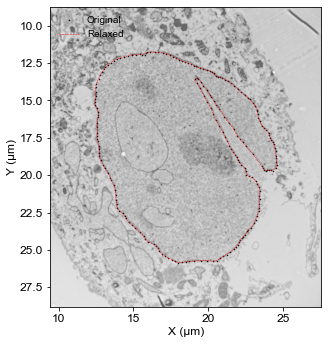

In [ ]:
from variation_relax import preprocess_mesh, relax_bending, generate_relaxation_movie, plot_contour

coords, original_coords = preprocess_mesh(
    file, resample_geometry=True, n_vertices=1000
)
params = {
    file.stem: {
        "dt": 1e-5,
        "n_iter": int(8e2),
        "Kb": 1,
        "Ksg": 1,
        "Ksl": 0.1,
    },
}
relaxed_coords = relax_bending(coords, **params[file.stem])
np.savez(
    f"relaxed_coords/{file.stem}",
    relaxed_coords=relaxed_coords,
    original_coords=original_coords,
)
fig = plt.figure(figsize=(5, 5))
plot_contour(
    fig,
    file.stem,
    original_coords,
    relaxed_coords,
)
fig.set_tight_layout(True)
plt.savefig("relaxed_coords/" + file.stem + ".png")
plt.show()


### Non-dimensionalization
Because the exact material properties of the nuclear membrane are unknown, non-dimensional parameter variation enables efficient exploration across physical regimes.
We need to choose a length scale to compare the magnitude of material properties, namely the surface tension and bending rigidity. To reflect the competition between surface tension and bending rigidity at highly stressed region, we choose the curvature scale $C_0$ to be the maximum absolute curvture of the geometry, which varies for each image. Then we can define a dimensionless surface tension $\bar{\sigma} = \frac{\sigma}{\kappa_b C_0^2}$, and sweep from 0 to $\bar{\sigma}_{\text{max}}$. We obtain the transition of membrane from bending dominated to tension dominate regimes.
<!-- We first choose two scaling parameters bending rigidity $\kappa_b$ and curvature $C_0$. First, we scale the coordinates of trace by $C_0$ before importing it into the energy evaluation. By fixing the dimensionless bending rigidity $\bar{\kappa_b} = 1$, we conduct parameter sweep on the nondimensional surface tension $\bar{\sigma} (= \frac{\sigma}{\kappa_b C_0^2} )$. The resultant force computed $\bar{f} = \frac{\bar{\nabla} \overline{(E/l)}}{d\bar{s}} $ is therefore also dimensionless. If needed, we can recover the force with unit by scaling it using the relationship $f = \kappa_b C_0^3 \bar{f} $.  -->
<!-- We obtain the value for ${\kappa_b}$ from Lipowsky et al., 1991 and the range for ${\sigma}$ from Gautheir et al., 2012, while the length scale is approximately the radius of our cells.
Bending rigidity (${\kappa_b}$): $10^{-19} J$ or ${10^{-7}}$ $\mathrm{\frac{kg~{\mu m^2}}{s^2}}$
Surface tension (${\sigma}$): $0.01$ to $0.04$ $\mathrm{\frac{mN}{m}}$ or ${10^{-5}}$ to ${4~*~10^{-5}}$ $\mathrm{\frac{kg}{s^2}}$
To non-dimensionalize the relationship between the bending rigidity, ${\kappa_b}$, and the surface tension, ${\sigma}$, we calculate the range of values for:
$$\mathrm{({\sigma}~*~{\frac{1}{\kappa_b}})~*~(length~scale){^2}}$$
Minimum:
$$\mathrm{{\frac{10^{-5}~kg}{1~{s^2}}}~*~{\frac{1~{s^2}}{10^{-7}~kg~\mu {m^2}}}~*~(5~\mu m){^2}~=~2500}$$
Maximum:
$$\mathrm{{\frac{4~*~10^{-5}~kg}{1~{s^2}}}~*~{\frac{1~{s^2}}{10^{-7}~kg~\mu {m^2}}}~*~(5~\mu m){^2}~=~10000}$$ -->

In [ ]:
from variation_run import get_dimensional_tension, get_force_density

_Ksg_=np.linspace(0, 0.3, 1 + 2**5)

Ksg_force = []
data = np.load(f"relaxed_coords/{file.stem}.npz")
relaxed_coords = data["relaxed_coords"]
for Ksg_ in _Ksg_:
    # Instantiate material properties
    Kb = 0.1
    Ksg = get_dimensional_tension(Ksg_, Kb, relaxed_coords)
    parameters = {
        "Kb": Kb / 4,  # Bending modulus (pN um; original 1e-19 J)
        "Ksg": Ksg,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
        "Ksl": 0,
    }
    # print(f"Dimensional tension of dimensionless tension {Ksg_} ==> ", Ksg)
    # Ksg_coords_force.append(np.concatenate(([relaxed_coords], relaxed_forces), axis=0))
    Ksg_force.append(get_force_density(parameters, relaxed_coords))
Ksg_force = np.asarray(Ksg_force)
np.savez(f"forces/{file.stem}", _Ksg_=_Ksg_, Ksg_force=Ksg_force)

### Identify the plausible physical regime
We predict that actin needs to pull in bending dominated and push in tension dominated regimes. 

In [ ]:
from variation_view import plot_force

data = np.load(f"forces/{file.stem}.npz")
_Ksg_ = data["_Ksg_"]
Ksg_force = data["Ksg_force"]
data = np.load(f"relaxed_coords/{file.stem}.npz")
relaxed_coords = data["relaxed_coords"]
original_coords = data["original_coords"]

fig = plt.figure(figsize=(5, 5))

moviewriter = animation.FFMpegWriter(fps=10)
with moviewriter.saving(fig, f"videos/{file.stem}.mp4", dpi=200):
    for Ksg_count, Ksg_ in tqdm(enumerate(_Ksg_), desc="Rendering plots"):
        forces = Ksg_force[Ksg_count]
        total_force = np.sum(forces, axis=0)
        plot_force(
            fig,
            file.stem,
            original_coords,
            relaxed_coords,
            total_force,
            _Ksg_,
            Ksg_,
            style="quiver",
        )
        plt.savefig(
            "figures/" + file.stem + f"_Ksg{math.floor(Ksg_*1000)}" + ".png"
        )
        moviewriter.grab_frame()
        fig.clear()
Video(f"videos/{file.stem}.mp4")

Rendering plots: 0it [00:00, ?it/s]

<Figure size 360x360 with 0 Axes>

### Example dimensional model in tension dominated regime
We assume the parameter $\kappa_b= 0.1 \mathrm{ pN μ m} \approx 24 k_B T$ and $\sigma= 50 \mathrm{pN/μ m}$. The membrane force density of *34D-grid2-s3-acta1_001_16* can be estimated.

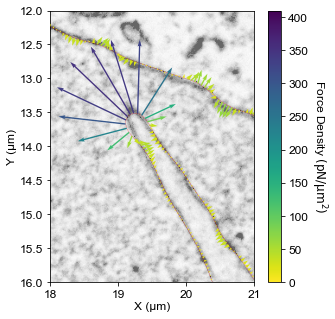

In [ ]:
import numpy as np
def plot_dimensional(total_force): 
    fig = plt.figure(figsize=(5, 5))

    x_lim = np.array([18, 21])
    y_lim = np.array([12, 16])
        
    ax = fig.add_subplot(autoscale_on=False, xlim=x_lim, ylim=y_lim)
    # flip y-axis
    ax.set_ylim(ax.get_ylim()[::-1])
    with Image.open(f"../raw_images/{file.stem}.TIF") as im:
        pixel_scale = images[file.stem]
        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im,
            alpha=0.6,
            extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]),
            zorder=0,
            cmap=plt.cm.Greys_r,
        )

    ax.set_ylabel(r"Y (μm)")
    ax.set_xlabel(r"X (μm)")

    # Shrink current axis
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    f_mag = np.linalg.norm(total_force, axis=1)
    q = ax.quiver(
        relaxed_coords[:, 0],
        relaxed_coords[:, 1],
        -total_force[:, 0],
        -total_force[:, 1],
        f_mag,
        cmap=mpl.cm.viridis_r,
        angles="xy",
        units="xy",
        label="force",
        scale=300,
        scale_units="xy",
        width=0.02,
        zorder=10,
    )
    cbar = fig.colorbar(
        q,
        ax=ax,
    )
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel("Force Density $\mathrm{(pN/\mu m^2)}$", rotation=270)
    # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    # cbar.ax.set_ylabel("Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)
    (line,) = ax.plot(
        relaxed_coords[:, 0], relaxed_coords[:, 1], linewidth=0.2, color="r"
    )

    # outline plots
    (original_line,) = ax.plot(
        original_coords[:, 0],
        original_coords[:, 1],
        "-o",
        markersize=0.2,
        linewidth=0.1,
        color="k",
    )
    

parameters = {
    "Kb": 0.1 / 4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 1,
}

forces = get_force_density(parameters, relaxed_coords)
total_force = np.sum(forces, axis=0)
plot_dimensional(total_force)
plt.show()



#### Napkin math of estimating actin coverage 
Assuming an actin filament is ~7 $\mathrm{nm}$ in diameter a conservative surface area occupancy is 4.9e-5 $\mathrm{μ m^2}$. Depending on cell conditions a single actin filament can produce ~1 $\mathrm{pN}$ of force. Then we can compute the maximum force density assuming full coverage. Naively assuming that force from actin linearly scale with its occupacy, and there is no branching and additional magnification mechanism, the area converage can be estimated.

In [ ]:
actin_force_density = 1.0 / 4.9e-5  # pN/um^2
print("Actin force density:", actin_force_density, "pN/um^2")
f_mag = np.linalg.norm(total_force, axis=1)
print(
    "Max force density of membrane:",
    np.max(f_mag),
    "pN/um^2;",
)
print("Coverage:", np.max(f_mag) / actin_force_density * 100, "%")
dualLengths = ClosedPlaneCurveGeometry.vertex_dual_length(relaxed_coords)
# print("Total force per length on membrane:", np.sum(f_mag* dualLengths), "pN/um")

Actin force density: 20408.163265306124 pN/um^2
Max force density of membrane: 409.6339828093539 pN/um^2;
Coverage: 2.0072065157658336 %
